В данном ноутбуке представлены эксперименты с использованием сверточных нейронных сетей.

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import re
import sys
import os

import numpy as np
from tqdm import tqdm
import pandas as pd
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from gensim.models import word2vec
from pymorphy3 import MorphAnalyzer
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from navec import Navec
import gensim.downloader as api
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import seaborn as sns
import warnings

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

RANDOM_STATE = 41825352

sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

torch.set_float32_matmul_precision('medium')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Загрузим данные которые были предобработаны в ноутбуке `min_baseline.ipynb`.

In [2]:
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

Предобработаем тексты пресс-релизов.

In [3]:
# инициализируем лемматизатор
mystem = Mystem()

# загружаем стоп-слова
STOP_WORDS = set(stopwords.words("russian"))


# функция для препроцессинга текста
def preprocessor(text):

    # приводим к нижнему регистру
    text = text.lower()

    # удаляем все символы, кроме пробелов и русских букв.
    regex = re.compile("[^а-я А-ЯЁё]")
    text = regex.sub(" ", text)

    # лемматизируем тексты
    text = " ".join(mystem.lemmatize(text))

    # удаляем стоп-слова
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])
    return text


Xpreproc = X.release.apply(preprocessor)

### Word2Vec

Обучим Word2Vec на нашем датасете и подготовим эмбеддинги. Сеть будет принимать на вход тензор размерность `batch_size x max_sent_len x embedding_size`, где `max_send_len` - число токенов в самом длинном тексте. Остальные тексты должны быть дополнены до данного размера при помощи отдельного токена.

In [4]:
PADDING_TOKEN = '<pad>' # токен для паддинга
EMBEDDING_SIZE = 50

# добавляем токен в каждый текст, чтобы w2v при обучении запомнил его
data = Xpreproc.str.split().apply(lambda x: x + [PADDING_TOKEN])
w2v = word2vec.Word2Vec(data, window=5, workers=1, sg=0, vector_size=EMBEDDING_SIZE, seed=RANDOM_STATE)

In [5]:
class EmbeddingVectors:
    """
    Контейнер для эмбеддингов всех слов из словаря
    """
    def __init__(self, vectors, padding_idx=None):
        self.vectors = vectors
        self.padding_idx = padding_idx
        self._size = vectors.shape[1]

    @property
    def size(self):
        return self._size

    @staticmethod
    def from_w2v(w2v: word2vec.Word2Vec, padding_token):
        return EmbeddingVectors(w2v.vectors, w2v.get_index(padding_token) if padding_token else None)
    
    @staticmethod
    def from_tfidf(tfidf: TfidfVectorizer):
        return EmbeddingVectors(np.zeros((1, len(tfidf.vocabulary_))))
    
    @staticmethod
    def from_navec(data):
        return EmbeddingVectors(data.pq.unpack(), data.vocab[PADDING_TOKEN])

Ниже представлена сверточная модель, реализованная по [Zhang, 2015](https://arxiv.org/abs/1510.03820).

In [6]:
class CnnTextClassifier(nn.Module):
    def __init__(self, embeddings, num_classes, window_sizes=(3, 4, 5), num_filters=256):
        super().__init__()
        
        self.embedding = nn.Embedding.from_pretrained(
            torch.FloatTensor(embeddings.vectors),
            padding_idx=embeddings.padding_idx,
        )
        
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (window_size, embeddings.size), padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(num_filters * len(window_sizes), num_classes),
        )

    def forward(self, x):
        x = self.embedding(x)

        if len(x.size()) < 4:
            x = torch.unsqueeze(x, 1)
        
        xs = []
        for conv in self.convs:
            x2 = torch.relu(conv(x)).squeeze(-1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        
        x = torch.cat(xs, dim=2)

        logits = self.head(x)
        probs = F.softmax(logits, dim=1)

        return probs

Далее преобразуем слова каждого текста в индексы из словаря Word2Vec, кодируем целевую переменную (для работы с `CrossEntropyLoss`).

In [7]:
def make_word2vec_vector_cnn(sentence, wv, padding_idx, max_len):
    padded_X = [padding_idx for i in range(max_len)]
    i = 0
    for word in sentence:
        if word not in wv:
            padded_X[i] = 0
        else:
            padded_X[i] = wv.get_index(word)
        i += 1
    return torch.tensor(padded_X, dtype=torch.long).view(1, -1)

In [8]:
padding_idx = w2v.wv.get_index(PADDING_TOKEN)
max_len = data.apply(len).max()

target_enc = LabelEncoder()
y_enc = target_enc.fit_transform(y)

data1 = torch.stack(data.apply(lambda x: make_word2vec_vector_cnn(x, w2v.wv, padding_idx, max_len)).tolist()).squeeze(1).to(device)
y1 = torch.tensor(y_enc, dtype=torch.long).to(device)

Наконец, обучим модель:

In [ ]:
def train(X, y, num_epochs, factory, start_from=30):
    y_preds = []
    y_preds_proba = []

    prog = tqdm(range(start_from, len(y)))
    for threshold in prog:
        ds = TensorDataset(X[:threshold], y[:threshold])
        dl = DataLoader(ds, 32, shuffle=False)
        
        cnn_model, optimizer, scheduler = factory()
        cnn_model.to(device)
        loss_function = nn.CrossEntropyLoss()

        cnn_model.train()
        for epoch in range(num_epochs):
            for bx, by in dl:
                cnn_model.zero_grad()
                probs = cnn_model(bx)
                loss = loss_function(probs, by)
                loss.backward()
                optimizer.step()

            if scheduler:
                scheduler.step()
            if epoch % 20 == 0:
                prog.set_postfix_str(f'loss = {loss.item()}, lr = {optimizer.param_groups[0]['lr']}')

        cnn_model.eval()
        probs = cnn_model(X[threshold:threshold+1])
        pred = torch.argmax(probs)
        y_preds_proba.append(probs.detach().cpu().numpy().reshape(-1))
        y_preds.append(pred.detach().cpu().numpy().item())

    return np.array(y_preds), np.array(y_preds_proba)

In [10]:
def create_model():
    embeddings = EmbeddingVectors.from_w2v(w2v.wv, PADDING_TOKEN)
    cnn_model = CnnTextClassifier(embeddings, num_classes=3)
    optimizer = optim.AdamW(cnn_model.parameters(), lr=0.001, fused=True)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500, 800])
    return cnn_model, optimizer, scheduler


num_epochs = 1000
y_preds, y_preds_proba = train(data1, y1, num_epochs, create_model)

100%|██████████| 70/70 [22:32<00:00, 19.32s/it, loss = 0.551444947719574, lr = 1e-05]  


Посмотрим на получившиеся метрики:

In [11]:
def print_metrics(name, y, y_preds, y_preds_proba, start_from=30):
    y = y[start_from:]
    acc = accuracy_score(y, y_preds)
    f1 = f1_score(y, y_preds, average="macro")
    recall = recall_score(y, y_preds, average="macro")
    precision = precision_score(y, y_preds, average="macro")
    roc_auc_ovr = roc_auc_score(y, y_preds_proba, average="macro", multi_class="ovr")
    roc_auc_ovo = roc_auc_score(y, y_preds_proba, average="macro", multi_class="ovo")

    print(classification_report(y, y_preds))
    cm = confusion_matrix(y, y_preds)
    cm = pd.DataFrame(cm, index=["-1", "0", "1"], columns=["-1", "0", "1"])
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return pd.DataFrame({
        'accuracy': acc,
        'f1': f1,
        'recall': recall,
        'precision': precision,
        'roc_auc_ovr': roc_auc_ovr,
        'roc_auc_ovo': roc_auc_ovo,
        }, index=[name])

              precision    recall  f1-score   support

        -1.0       0.62      0.57      0.59        23
         0.0       0.50      0.64      0.56        28
         1.0       0.77      0.53      0.62        19

    accuracy                           0.59        70
   macro avg       0.63      0.58      0.59        70
weighted avg       0.61      0.59      0.59        70



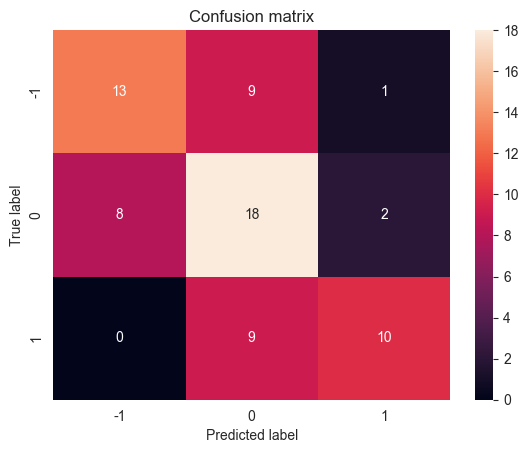

In [12]:
metric = print_metrics('CNN Word2Vec', y, target_enc.inverse_transform(y_preds), y_preds_proba)

In [13]:
metrics = pd.concat([metrics, metric], axis=0)
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
MLP TF-IDF,0.671429,0.675072,0.679416,0.671795,0.755827,0.759868
MLP TF-IDF + feature selection,0.614286,0.615343,0.615343,0.615343,0.715193,0.717330
CNN Word2Vec,0.585714,0.592803,0.578130,0.629426,0.694751,0.699371


Качество модели не слишком высокое в сравнении даже с линейными моделями.

### Предобученный Word2Vec

Попробуем использовать предобученную модель Word2Vec на большом объеме текстов вместо обучения собственной модели.

In [14]:
w2v_ruscorpora = api.load('word2vec-ruscorpora-300')

# функция для добавления части речи к словам
def tag(words):
    morph = MorphAnalyzer()
    parts = [str(morph.parse(word)[0].tag.POS) for word in words]
    return [word + '_' + part for word, part in zip(words, parts)]

data = Xpreproc.str.split().apply(tag)

В предобученной модели нет токена для паддинга, используем для этих целей слово, не встречающееся в исходных текстах.

In [15]:
padding_idx = 9999
max_len = data.apply(len).max()

data1 = torch.stack(data.apply(lambda x: make_word2vec_vector_cnn(x, w2v_ruscorpora, padding_idx, max_len)).tolist()).squeeze(1).to(device)

Обучим модель и посмотрим на метрики.

In [16]:
def create_model():
    embeddings = EmbeddingVectors.from_w2v(w2v_ruscorpora, w2v_ruscorpora.index_to_key[padding_idx])
    cnn_model = CnnTextClassifier(embeddings, num_classes=3)
    optimizer = optim.AdamW(cnn_model.parameters(), lr=0.001, fused=True)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500, 800])
    return cnn_model, optimizer, scheduler


num_epochs = 1000
y_preds, y_preds_proba = train(data1, y1, num_epochs, create_model)

100%|██████████| 70/70 [1:34:35<00:00, 81.08s/it, loss = 0.5514478087425232, lr = 1e-05]  


              precision    recall  f1-score   support

        -1.0       0.65      0.65      0.65        23
         0.0       0.55      0.57      0.56        28
         1.0       0.67      0.63      0.65        19

    accuracy                           0.61        70
   macro avg       0.62      0.62      0.62        70
weighted avg       0.62      0.61      0.61        70



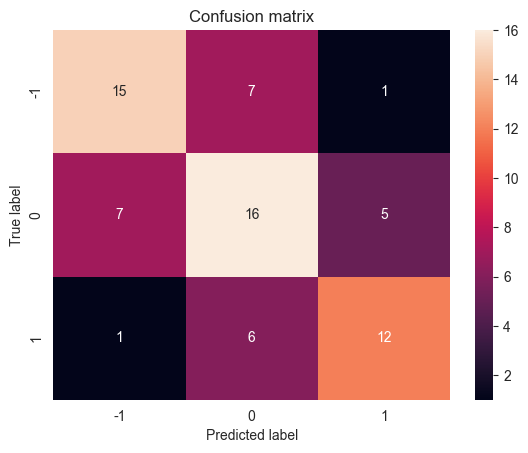

In [17]:
metric = print_metrics('CNN Word2Vec pretrained', y, target_enc.inverse_transform(y_preds), y_preds_proba)

In [18]:
metrics = pd.concat([metrics, metric], axis=0)
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
MLP TF-IDF,0.671429,0.675072,0.679416,0.671795,0.755827,0.759868
MLP TF-IDF + feature selection,0.614286,0.615343,0.615343,0.615343,0.715193,0.717330
CNN Word2Vec,0.585714,0.592803,0.578130,0.629426,0.694751,0.699371
CNN Word2Vec pretrained,0.614286,0.620742,0.618394,0.623522,0.743324,0.749373


Результат получилось значительно улучшить, однако, он не дотягивает до качества лучших классических моделей.

### Предобученный Glove

Попробуем обучить сеть, используя в качестве векторного представления слов GloVe. Схема обучения сети аналогична Word2Vec.

In [19]:
glove = Navec.load('navec_news_v1_1B_250K_300d_100q.tar')

In [20]:
data = Xpreproc.str.split()

padding_idx = glove.vocab[PADDING_TOKEN]
max_len = data.apply(len).max()

In [21]:
def make_word2vec_vector_cnn(sentence, glove, padding_idx, max_len):
    padded_X = [padding_idx for i in range(max_len)]
    i = 0
    for word in sentence:
        if word not in glove:
            padded_X[i] = glove.vocab['<unk>']
        else:
            padded_X[i] = glove.vocab[word]
        i += 1
    return torch.tensor(padded_X, dtype=torch.long).view(1, -1)

In [22]:
data1 = torch.stack(data.apply(lambda x: make_word2vec_vector_cnn(x, glove, padding_idx, max_len)).tolist()).squeeze(1).to(device)

In [23]:
def create_model():
    embeddings = EmbeddingVectors.from_navec(glove)
    cnn_model = CnnTextClassifier(embeddings, num_classes=3)
    optimizer = optim.AdamW(cnn_model.parameters(), lr=0.001, fused=True)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500, 800])
    return cnn_model, optimizer, scheduler

num_epochs = 1000
y_preds, y_preds_proba = train(data1, y1, num_epochs, create_model)

100%|██████████| 70/70 [1:35:18<00:00, 81.70s/it, loss = 0.5514447689056396, lr = 1e-05]  


              precision    recall  f1-score   support

        -1.0       0.59      0.70      0.64        23
         0.0       0.55      0.57      0.56        28
         1.0       0.64      0.47      0.55        19

    accuracy                           0.59        70
   macro avg       0.60      0.58      0.58        70
weighted avg       0.59      0.59      0.58        70



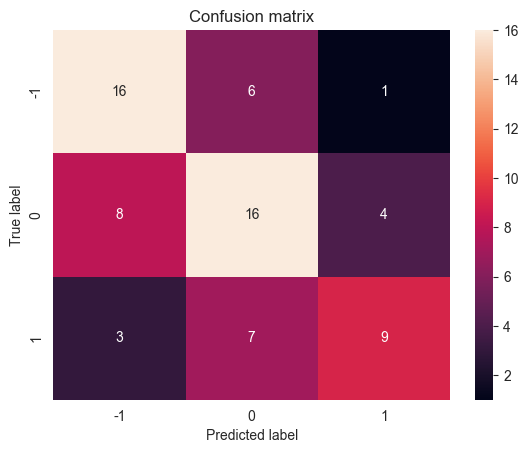

In [24]:
metric = print_metrics('CNN Glove pretrained', y, target_enc.inverse_transform(y_preds), y_preds_proba)

In [25]:
metrics = pd.concat([metrics, metric], axis=0)
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
MLP TF-IDF,0.671429,0.675072,0.679416,0.671795,0.755827,0.759868
MLP TF-IDF + feature selection,0.614286,0.615343,0.615343,0.615343,0.715193,0.717330
CNN Word2Vec,0.585714,0.592803,0.578130,0.629426,0.694751,0.699371
CNN Word2Vec pretrained,0.614286,0.620742,0.618394,0.623522,0.743324,0.749373
CNN Glove pretrained,0.585714,0.582286,0.580255,0.595725,0.673426,0.674969


Качество модели хуже варианта Word2Vec.

### One-Hot Encoding

Простейший способ получить эмбеддинги слов - one-hot кодирование. Для этого подготовим словарь всех слов из пресс-релизов и каждому слову поставим в соответствие вектор, где на позиции слова в словаре будет стоять 1.

In [26]:
splitted = Xpreproc.str.split()
vocab = list(set(splitted.explode())) + [PADDING_TOKEN]
vocab_dict = {k: v for v, k in enumerate(vocab)}
vectors = torch.eye(len(vocab))

max_len = splitted.apply(len).max()
padded = splitted.apply(lambda lst: lst + [PADDING_TOKEN] * (max_len - len(lst)))
one_hot = padded.apply(lambda lst: list(map(lambda x: vocab_dict[x], lst)))

Кодируем слова в текстах их индексами в словаре:

In [27]:
data1 = torch.stack(one_hot.apply(torch.tensor).tolist()).to(device)

Обучаем модель:

In [28]:
embeddings = EmbeddingVectors(vectors, len(vocab) - 1)

def create_model():
    cnn_model = CnnTextClassifier(embeddings, num_classes=3)
    optimizer = optim.AdamW(cnn_model.parameters(), lr=0.001, fused=True)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[250, 400])
    return cnn_model, optimizer, scheduler

num_epochs = 500
y_preds, y_preds_proba = train(data1, y1, num_epochs, create_model)

100%|██████████| 70/70 [3:09:13<00:00, 162.19s/it, loss = 0.5514761805534363, lr = 1e-05]   


              precision    recall  f1-score   support

        -1.0       0.64      0.70      0.67        23
         0.0       0.57      0.57      0.57        28
         1.0       0.76      0.68      0.72        19

    accuracy                           0.64        70
   macro avg       0.66      0.65      0.65        70
weighted avg       0.65      0.64      0.64        70



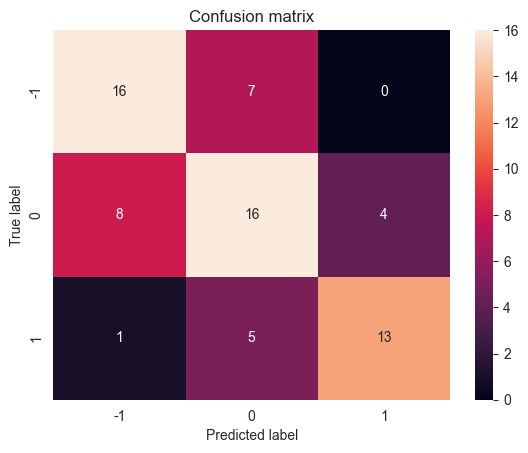

In [29]:
metric = print_metrics('CNN OHE', y, target_enc.inverse_transform(y_preds), y_preds_proba)

In [30]:
metrics = pd.concat([metrics, metric], axis=0)
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
MLP TF-IDF,0.671429,0.675072,0.679416,0.671795,0.755827,0.759868
MLP TF-IDF + feature selection,0.614286,0.615343,0.615343,0.615343,0.715193,0.717330
CNN Word2Vec,0.585714,0.592803,0.578130,0.629426,0.694751,0.699371
CNN Word2Vec pretrained,0.614286,0.620742,0.618394,0.623522,0.743324,0.749373
CNN Glove pretrained,0.585714,0.582286,0.580255,0.595725,0.673426,0.674969
CNN OHE,0.642857,0.653439,0.650430,0.658711,0.776107,0.782336


Интересно, что one-hot кодирование показало практически такой же результат, как GloVe.

### 1D TF-IDF

Кодирование TF-IDF также можно рассматривать в качестве векторного представления слов - только вектор получается одномерным.

In [31]:
vectorizer = TfidfVectorizer(max_df=0.9, min_df=8)
tf_idf = vectorizer.fit_transform(Xpreproc).todense()

Немного модифицируем исходную сеть и уберем из нее слой для подстановки векторов вместо индексов токенов - у нас уже есть векторное представление в явном виде.

In [32]:
class TfIdfCnnTextClassifier(CnnTextClassifier):
    def __init__(self, embeddings, num_classes, window_sizes=(3, 4, 5), num_filters=256):
        super().__init__(embeddings, num_classes, window_sizes, num_filters)
        self.embedding = nn.Identity()

Подготавливаем данные, обучаем модель и посмотрим на метрики.

In [33]:
target_enc = LabelEncoder()
y_enc = target_enc.fit_transform(y)

data1 = torch.tensor(tf_idf, dtype=torch.float).unsqueeze(1).to(device)
y1 = torch.tensor(y_enc, dtype=torch.long).to(device)

In [34]:
def create_model():
    embeddings = EmbeddingVectors.from_tfidf(vectorizer)
    cnn_model = TfIdfCnnTextClassifier(embeddings, num_classes=3)
    optimizer = optim.AdamW(cnn_model.parameters(), lr=0.001, fused=True)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500, 800])
    return cnn_model, optimizer, scheduler


num_epochs = 1000
y_preds, y_preds_proba = train(data1, y1, num_epochs, create_model)

100%|██████████| 70/70 [39:03<00:00, 33.48s/it, loss = 0.5514509677886963, lr = 1e-05] 


              precision    recall  f1-score   support

        -1.0       0.71      0.74      0.72        23
         0.0       0.62      0.57      0.59        28
         1.0       0.70      0.74      0.72        19

    accuracy                           0.67        70
   macro avg       0.67      0.68      0.68        70
weighted avg       0.67      0.67      0.67        70



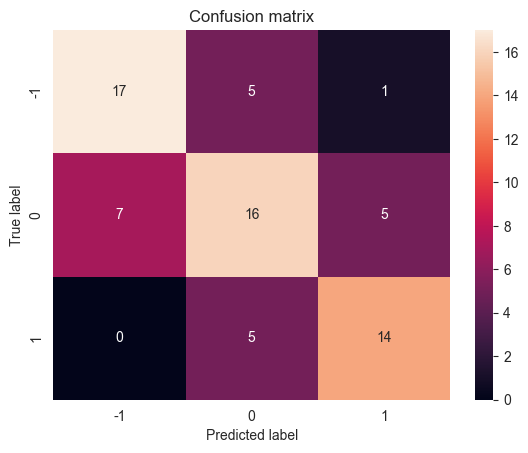

In [35]:
metric = print_metrics('CNN tf-idf', y, target_enc.inverse_transform(y_preds), y_preds_proba)

In [36]:
metrics = pd.concat([metrics, metric], axis=0)
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
MLP TF-IDF,0.671429,0.675072,0.679416,0.671795,0.755827,0.759868
MLP TF-IDF + feature selection,0.614286,0.615343,0.615343,0.615343,0.715193,0.717330
CNN Word2Vec,0.585714,0.592803,0.578130,0.629426,0.694751,0.699371
CNN Word2Vec pretrained,0.614286,0.620742,0.618394,0.623522,0.743324,0.749373
CNN Glove pretrained,0.585714,0.582286,0.580255,0.595725,0.673426,0.674969
CNN OHE,0.642857,0.653439,0.650430,0.658711,0.776107,0.782336
CNN tf-idf,0.671429,0.677982,0.682467,0.674573,0.764051,0.769750


Результат получился чуть лучше по сравнению с предобученным Word2Vec. В целом сверточная сеть не показала хорошего результата ни в одном из вариантов.

In [37]:
metrics.to_csv('metrics.csv')